In [87]:
import os

os.chdir('/home/yry08/yigedabuliu/lkq/LiteMedSAM')

In [88]:
import random
import monai
from os import listdir, makedirs
from os.path import join, exists, isfile, isdir, basename
from glob import glob
from tqdm import tqdm, trange
from copy import deepcopy
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

from segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
from tiny_vit_sam import TinyViT
import cv2
import torch.nn.functional as F

import argparse

In [89]:
class NpyDataset(Dataset):
    def __init__(self, data_root, image_size=256, bbox_shift=5, data_aug=True):
        self.data_root = data_root
        self.gt_path = join(data_root, 'gts')
        self.img_path = join(data_root, 'imgs')
        self.gt_path_files = sorted(glob(join(self.gt_path, '*.npy'), recursive=True))
        self.gt_path_files = [
            file for file in self.gt_path_files
            if isfile(join(self.img_path, basename(file)))
        ]
        self.image_size = image_size
        self.target_length = image_size
        self.bbox_shift = bbox_shift
        self.data_aug = data_aug

    def __len__(self):
        return len(self.gt_path_files)

    def __getitem__(self, index):
        img_name = basename(self.gt_path_files[index])
        assert img_name == basename(self.gt_path_files[index]), 'img gt name error' + self.gt_path_files[index] + \
                                                                self.npy_files[index]
        img_3c = np.load(join(self.img_path, img_name), 'r', allow_pickle=True)  # (H, W, 3)
        img_resize = self.resize_longest_side(img_3c)
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8,
                                                               a_max=None)  # normalize to [0, 1], (H, W, 3
        img_padded = self.pad_image(img_resize)  # (256, 256, 3)
        # convert the shape to (3, H, W)
        img_padded = np.transpose(img_padded, (2, 0, 1))  # (3, 256, 256)
        assert np.max(img_padded) <= 1.0 and np.min(img_padded) >= 0.0, 'image should be normalized to [0, 1]'
        gt = np.load(self.gt_path_files[index], 'r', allow_pickle=True)  # multiple labels [0, 1,4,5...], (256,256)
        gt = cv2.resize(
            gt,
            (img_resize.shape[1], img_resize.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(np.uint8)
        gt = self.pad_image(gt)  # (256, 256)
        label_ids = np.unique(gt)[1:]
        try:
            gt2D = np.uint8(gt == random.choice(label_ids.tolist()))  # only one label, (256, 256)
        except:
            print(img_name, 'label_ids.tolist()', label_ids.tolist())
            gt2D = np.uint8(gt == np.max(gt))  # only one label, (256, 256)
        # add data augmentation: random fliplr and random flipud
        if self.data_aug:
            if random.random() > 0.5:
                img_padded = np.ascontiguousarray(np.flip(img_padded, axis=-1))
                gt2D = np.ascontiguousarray(np.flip(gt2D, axis=-1))
                # print('DA with flip left right')
            if random.random() > 0.5:
                img_padded = np.ascontiguousarray(np.flip(img_padded, axis=-2))
                gt2D = np.ascontiguousarray(np.flip(gt2D, axis=-2))
                # print('DA with flip upside down')
        gt2D = np.uint8(gt2D > 0)
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        return {
            "image": torch.tensor(img_padded).float(),
            "gt2D": torch.tensor(gt2D[None, :, :]).long(),
            "bboxes": torch.tensor(bboxes[None, None, ...]).float(),  # (B, 1, 4)
            "image_name": img_name,
            "new_size": torch.tensor(np.array([img_resize.shape[0], img_resize.shape[1]])).long(),
            "original_size": torch.tensor(np.array([img_3c.shape[0], img_3c.shape[1]])).long()
        }

    def resize_longest_side(self, image):
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        long_side_length = self.target_length
        oldh, oldw = image.shape[0], image.shape[1]
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww, newh = int(neww + 0.5), int(newh + 0.5)
        target_size = (neww, newh)

        return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    def pad_image(self, image):
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        # Pad
        h, w = image.shape[0], image.shape[1]
        padh = self.image_size - h
        padw = self.image_size - w
        if len(image.shape) == 3:  ## Pad image
            image_padded = np.pad(image, ((0, padh), (0, padw), (0, 0)))
        else:  ## Pad gt mask
            image_padded = np.pad(image, ((0, padh), (0, padw)))

        return image_padded

In [90]:
# 构建自定义的npy数据集

data_root = './data/npy'
train_dataset = NpyDataset(data_root=data_root, data_aug=True)


In [91]:
train_dataset.gt_path

'./data/npy/gts'

In [92]:
batch_size = 2
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


In [93]:
# train_loader.dataset[0] # 取数据
data = train_loader.dataset[0]

In [94]:
image = data['image']
gt2D = data["gt2D"]
boxes = data["bboxes"]

In [95]:
print(f'image shape:{image.shape}')
print(f'gt2D shape:{gt2D.shape}')
print(f'boxes shape:{boxes.shape}')

image shape:torch.Size([3, 256, 256])
gt2D shape:torch.Size([1, 256, 256])
boxes shape:torch.Size([1, 1, 4])


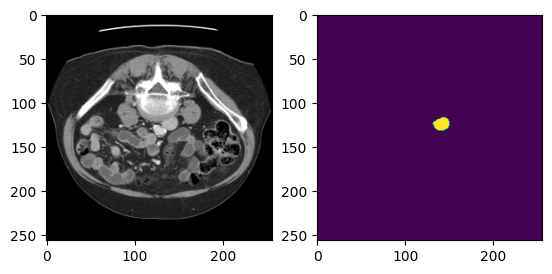

In [96]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)
axes[0].imshow(image.permute(1, 2, 0))
axes[1].imshow(gt2D.permute(1, 2, 0))
plt.show()
# plt.imshow(image.permute(1, 2, 0))

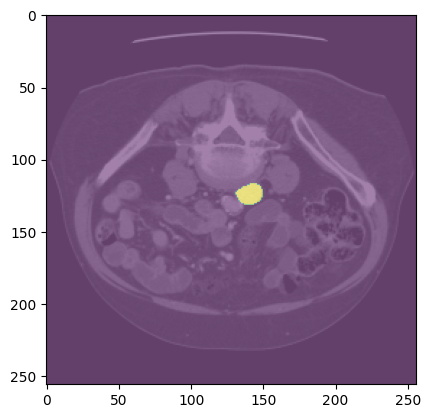

In [97]:
# 同时显示
plt.imshow(image.permute(1, 2, 0), alpha=0.5)
plt.imshow(gt2D.permute(1, 2, 0), alpha=0.5)
plt.show()

In [110]:
boxes

tensor([[[130.5000, 117.5000, 152.5000, 131.5000]]])

In [99]:

"""Embeds box prompts."""
boxes = boxes + 0.5  # Shift to center of pixel
coords = boxes.reshape(-1, 2, 2)

# coords = coords.clone()
# coords[:, :, 0] = coords[:, :, 0] / 255
# coords[:, :, 1] = coords[:, :, 1] / 255


In [100]:
coords

tensor([[[130.5000, 117.5000],
         [152.5000, 131.5000]]])

x:[130.5, 152.5]
y:[117.5, 131.5]


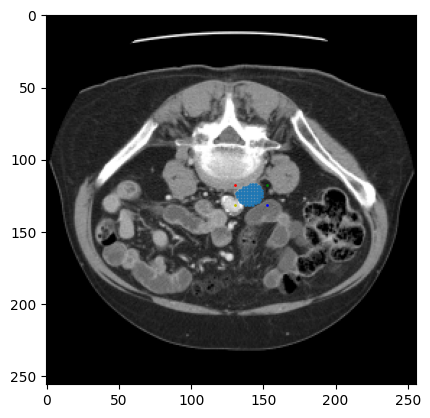

In [124]:
# 同时显示

new_gt = gt2D[0]
indices = torch.nonzero(new_gt)

plt.imshow(image.permute(1, 2, 0))
plt.scatter(x=indices[:, 1], y=indices[:, 0], s=0.5)
# 画box
x = [130.5,152.5]
y = [117.5,131.5]


print(f'x:{x}')
print(f'y:{y}')


# plt.plot([x[0],y[0]], [x[1],y[0]], c='r')
# plt.plot([x[0],y[0]], [x[1],y[0]], c='r')
# plt.plot([x[0],y[1]], [x[0],y[0]], c='r')
# plt.plot([x[0],y[0]], [x[1],y[0]], c='r')
# plt.plot(x, y, c='r')
# plt.plot(bbox_l_b, bbox_r_b, c='r')
# plt.plot(bbox_r_t, bbox_r_b, c='r')
# plt.plot((114,151),(131,136),c='r')
plt.scatter(x[0],y[0], s=1,c='r')
plt.scatter(x[1],y[0], s=1,c='g')
plt.scatter(x[0],y[1], s=1,c='y')
plt.scatter(x[1],y[1], s=1,c='b')
# plt.scatter(bbox_r_b,bbox_r_b, s=0.5,c='r')
# plt.scatter(bbox_l_t,bbox_r_t, s=0.5,c='r')

plt.show()

In [102]:
class MedSAM_Lite(nn.Module):
    def __init__(self,
                 image_encoder,
                 mask_decoder,
                 prompt_encoder
                 ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

    def forward(self, image, boxes):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)

        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None,
            boxes=boxes,
            masks=None,
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )  # (B, 1, 256, 256)

        return low_res_masks, iou_predictions

    @torch.no_grad()
    def postprocess_masks(self, masks, new_size, original_size):
        """
        Do cropping and resizing
        """
        # Crop
        masks = masks[:, :, :new_size[0], :new_size[1]]
        # Resize
        masks = F.interpolate(
            masks,
            size=(original_size[0], original_size[1]),
            mode="bilinear",
            align_corners=False,
        )

        return masks

In [103]:
medsam_lite_image_encoder = TinyViT(
    img_size=256,
    in_chans=3,
    embed_dims=[
        64,  ## (64, 256, 256)
        128,  ## (128, 128, 128)
        160,  ## (160, 64, 64)
        320  ## (320, 64, 64)
    ],
    depths=[2, 2, 6, 2],
    num_heads=[2, 4, 5, 10],
    window_sizes=[7, 7, 14, 7],
    mlp_ratio=4.,
    drop_rate=0.,
    drop_path_rate=0.0,
    use_checkpoint=False,
    mbconv_expand_ratio=4.0,
    local_conv_size=3,
    layer_lr_decay=0.8
)

medsam_lite_prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(256, 256),
    mask_in_chans=16
)

medsam_lite_mask_decoder = MaskDecoder(
    num_multimask_outputs=3,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8,
    ),
    transformer_dim=256,
    iou_head_depth=3,
    iou_head_hidden_dim=256,
)

medsam_lite_model = MedSAM_Lite(
    image_encoder=medsam_lite_image_encoder,
    mask_decoder=medsam_lite_mask_decoder,
    prompt_encoder=medsam_lite_prompt_encoder
)

In [104]:
medsam_lite_model

MedSAM_Lite(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
              (c): Conv2d

In [105]:
# 为数据增加批次维度

batch_iamge = image.unsqueeze(dim=0)
batch_boxes = boxes.unsqueeze(dim=0)
print(f'batch image and box shape:{batch_iamge.shape},{batch_boxes.shape}')

logits_pred, iou_pred = medsam_lite_model(batch_iamge, batch_boxes)

batch image and box shape:torch.Size([1, 3, 256, 256]),torch.Size([1, 1, 1, 4])


In [106]:
logits_pred.shape

torch.Size([1, 1, 256, 256])

new_image shape:torch.Size([256, 256, 3])


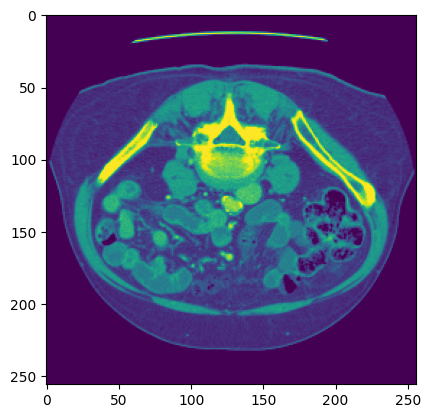

In [107]:
new_image = image.permute(1, 2, 0)
print(f'new_image shape:{new_image.shape}')
plt.imshow(new_image[:, :, 0])

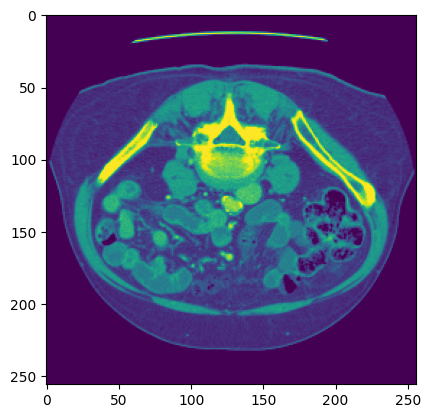

In [108]:
plt.imshow(new_image[:, :, 2])

In [109]:
torch.max(new_image[:, :, 0])

tensor(1.)